### Imports

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import hopsworks
import os
import warnings
from dotenv import load_dotenv
from pathlib import Path
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
load_dotenv()

api_key = os.getenv("HOPSWORKS_API_KEY")

project = hopsworks.login(host="eu-west.cloud.hopsworks.ai",
project="EarthTamagotchi", api_key_value=api_key)


2026-01-02 15:34:49,672 INFO: Initializing external client
2026-01-02 15:34:49,672 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-02 15:34:51,187 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/2177


In [3]:
fs = project.get_feature_store()
mr = project.get_model_registry()

## 🌫️ Inference pipeline for CO2

In [4]:
model_name = f"co2_trend_residual_model"
print(f"Retrieving model: {model_name}")

retrieved_model = mr.get_model(
    name=model_name,
    version=1,  # Get the latest version
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Retrieving model: co2_trend_residual_model
2026-01-02 15:34:56,388 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/1000 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/644910 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/137 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/48818 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/59797 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/135122 elapsed<00:00 remaining<?

In [5]:
# Load CO2 trend + residual models and normalization parameters from the downloaded directory

trend_model_path = Path(saved_model_dir) / "trend_model.pkl"
residual_model_path = Path(saved_model_dir) / "residual_model_gb.pkl"
params_path = Path(saved_model_dir) / "normalization_params.pkl"

print("Loading models from:", saved_model_dir)

trend_model = joblib.load(trend_model_path)
residual_model_gb = joblib.load(residual_model_path)
params = joblib.load(params_path)

bias_correction = params.get("bypass_correction", params.get("bias_correction", 0.0))

print("Loaded trend_model, residual_model_gb, and bias_correction")


Loading models from: /var/folders/9l/s0ldp1h1453gkrsny8rxfr3w0000gn/T/df819938-1142-4091-a5ef-c985d11d5078/co2_trend_residual_model/1
Loaded trend_model, residual_model_gb, and bias_correction


In [6]:
# Get batch data from CO₂ feature group
# We need historical data (at least 12 months) to build lag/rolling features for predictions

today = datetime.now().date()

co2_fg = fs.get_feature_group(
    name='global_co2',
    version=1,
)

# Get data from at least 12 months ago to today (to build lag_12 and roll_12 features)
# We'll use this historical data to seed our autoregressive predictions
# Use a longer lookback to ensure we get enough data (accounting for potential gaps)
lookback_months = 18
lookback_date = today - timedelta(days=lookback_months * 30)  # Approximate 18 months

batch_data_co2 = co2_fg.filter(
    co2_fg.date >= pd.Timestamp(lookback_date)
).read()

batch_data_co2


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


,date,average,trend,average_unc,average_lag_1,trend_lag_1,average_lag_2,trend_lag_2,average_lag_3,trend_lag_3,...,trend_roll_3,trend_roll_12,year,month,month_sin,month_cos,year_normalized,year_normalized_squared,year_month_sin,year_month_cos
0,2024-08-01,422.989990,424.890015,0.44,425.549988,425.140015,426.910004,424.459991,426.899994,423.660004,...,424.420003,423.160833,2024,8,-8.660254e-01,-5.000000e-01,0.984848,0.969927,-8.529038e-01,-4.924242e-01
1,2024-09-01,422.029999,425.429993,0.18,422.989990,424.890015,425.549988,425.140015,426.910004,424.459991,...,424.830007,423.436668,2024,9,-1.000000e+00,-1.836970e-16,0.984848,0.969927,-9.848485e-01,-1.809137e-16
2,2024-10-01,422.380005,425.630005,0.14,422.029999,425.429993,422.989990,424.890015,425.549988,425.140015,...,425.153341,423.730835,2024,10,-8.660254e-01,5.000000e-01,0.984848,0.969927,-8.529038e-01,4.924242e-01
3,2024-11-01,423.850006,425.869995,0.13,422.380005,425.630005,422.029999,425.429993,422.989990,424.890015,...,425.316671,424.027501,2024,11,-5.000000e-01,8.660254e-01,0.984848,0.969927,-4.924242e-01,8.529038e-01
4,2024-12-01,425.399994,426.130005,0.25,423.850006,425.869995,422.380005,425.630005,422.029999,425.429993,...,425.643331,424.310834,2024,12,-2.449294e-16,1.000000e+00,0.984848,0.969927,-2.412183e-16,9.848485e-01
5,2025-01-01,426.649994,426.350006,0.22,425.399994,426.130005,423.850006,425.869995,422.380005,425.630005,...,425.876668,424.606669,2025,1,5.000000e-01,8.660254e-01,1.000000,1.000000,5.000000e-01,8.660254e-01
6,2025-02-01,427.089996,426.160004,0.25,426.649994,426.350006,425.399994,426.130005,423.850006,425.869995,...,426.116669,424.927503,2025,2,8.660254e-01,5.000000e-01,1.000000,1.000000,8.660254e-01,5.000000e-01
7,2025-03-01,428.149994,426.690002,0.41,427.089996,426.160004,426.649994,426.350006,425.399994,426.130005,...,426.213338,425.138336,2025,3,1.000000e+00,6.123234e-17,1.000000,1.000000,1.000000e+00,6.123234e-17
8,2025-04-01,429.640015,427.140015,0.29,428.149994,426.690002,427.089996,426.160004,426.649994,426.350006,...,426.400004,425.368337,2025,4,8.660254e-01,-5.000000e-01,1.000000,1.000000,8.660254e-01,-5.000000e-01
9,2025-05-01,430.510010,427.269989,0.16,429.640015,427.140015,428.149994,426.690002,427.089996,426.160004,...,426.663340,425.629171,2025,5,5.000000e-01,-8.660254e-01,1.000000,1.000000,5.000000e-01,-8.660254e-01


In [7]:
# Autoregressive multi-month CO2 forecast using historical data to seed lag/rolling features

# Sort batch_data_co2 by date to ensure chronological order
batch_data_co2 = batch_data_co2.sort_values("date", ascending=True).copy()

# Get year normalization range from FULL historical dataset (same as in training)
# We need the full range, not just the last 12 months
co2_full_hist = co2_fg.read()  # Read all historical data
co2_full_hist['date'] = pd.to_datetime(co2_full_hist['date'])
co2_full_hist['year'] = pd.to_datetime(co2_full_hist['date']).dt.year

year_min = co2_full_hist['year'].min()
year_max = co2_full_hist['year'].max()

print(f"Year normalization range: {year_min} to {year_max}")

# Initialize historical values for autoregressive features
# We prefer at least 12 months of history for lag_12 and roll_12, but can work with less
if len(batch_data_co2) < 6:
    raise ValueError(f"Need at least 6 months of historical data, got {len(batch_data_co2)}")
elif len(batch_data_co2) < 12:
    print(f"Warning: Only {len(batch_data_co2)} months of historical data available. Some lag/roll features may use shorter windows.")

# Extract historical average and trend values
historical_average = list(batch_data_co2['average'].values)
historical_dates = pd.to_datetime(batch_data_co2['date']).values

# Calculate historical trend values for seeding trend_lag features
historical_trend_features = pd.DataFrame({
    'year': batch_data_co2['year'],
    'month': batch_data_co2['month'],
})
historical_trend_features['month_sin'] = np.sin(2 * np.pi * historical_trend_features['month'] / 12)
historical_trend_features['month_cos'] = np.cos(2 * np.pi * historical_trend_features['month'] / 12)
historical_trend_features['year_normalized'] = (historical_trend_features['year'] - year_min) / (year_max - year_min)
historical_trend_features['year_normalized_squared'] = historical_trend_features['year_normalized'] ** 2
historical_trend_features['year_month_sin'] = historical_trend_features['year_normalized'] * historical_trend_features['month_sin']
historical_trend_features['year_month_cos'] = historical_trend_features['year_normalized'] * historical_trend_features['month_cos']

trend_features = ['year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos']
historical_trend = list(trend_model.predict(historical_trend_features[trend_features]))

# Generate future dates for prediction (24 months ahead)
last_date = pd.to_datetime(batch_data_co2['date'].max())
future_dates = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=24,
    freq='MS'
)

# Helper function to build residual features from history lists
def make_co2_residual_features_from_history(avg_history, trend_history):
    # Build residual features from historical average and trend lists
    avg_arr = np.array(avg_history, dtype=float)
    trend_arr = np.array(trend_history, dtype=float)
    
    def lag(arr, k):
        if len(arr) < k:
            return np.nan
        return arr[-k]
    
    def roll(arr, k):
        if len(arr) < k:
            return np.nan
        return np.mean(arr[-k:])
    
    return {
        'average_lag_1': lag(avg_arr, 1),
        'average_lag_2': lag(avg_arr, 2),
        'average_lag_3': lag(avg_arr, 3),
        'average_lag_6': lag(avg_arr, 6),
        'average_lag_12': lag(avg_arr, 12),
        'average_roll_3': roll(avg_arr, 3),
        'average_roll_12': roll(avg_arr, 12),
        'trend_lag_1': lag(trend_arr, 1),
        'trend_lag_2': lag(trend_arr, 2),
        'trend_lag_3': lag(trend_arr, 3),
        'trend_lag_6': lag(trend_arr, 6),
        'trend_lag_12': lag(trend_arr, 12),
        'trend_roll_3': roll(trend_arr, 3),
        'trend_roll_12': roll(trend_arr, 12),
    }

# Initialize predictions list
predictions = []

# Iterate through future dates (autoregressive)
for dt in future_dates:
    year = dt.year
    month = dt.month
    
    # Build time features for this date
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    year_norm = (year - year_min) / (year_max - year_min)
    year_norm_sq = year_norm ** 2
    year_month_sin = year_norm * month_sin
    year_month_cos = year_norm * month_cos
    
    # 1. Predict trend part
    trend_row = pd.DataFrame([{
        'year_normalized': year_norm,
        'year_normalized_squared': year_norm_sq,
        'month_sin': month_sin,
        'month_cos': month_cos,
        'year_month_sin': year_month_sin,
        'year_month_cos': year_month_cos,
    }])
    trend_pred = float(trend_model.predict(trend_row[trend_features])[0])
    
    # 2. Build residual features from historical data
    resid_feats = make_co2_residual_features_from_history(historical_average, historical_trend)
    
    # 3. Predict residual part
    resid_row_df = pd.DataFrame([resid_feats])
    # Remove trend features from residual features (they're not used in residual model)
    resid_row_df = resid_row_df.drop(columns=[c for c in trend_features if c in resid_row_df.columns])
    residual_pred = float(residual_model_gb.predict(resid_row_df)[0])
    
    # 4. Combine trend + residual + bias correction
    co2_pred = trend_pred + residual_pred + bias_correction
    
    predictions.append({
        'date': dt,
        'predicted_co2': co2_pred,
        'trend': trend_pred,
        'residual': residual_pred,
    })
    
    # Update histories for next iteration (autoregressive)
    historical_average.append(co2_pred)
    historical_trend.append(trend_pred)

# Convert to DataFrame
predictions_df = pd.DataFrame(predictions)
predictions_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 
Year normalization range: 1959 to 2025


,date,predicted_co2,trend,residual
0,2025-12-01,424.870651,423.187432,1.683289
1,2026-01-01,428.474360,426.791141,1.683289
2,2026-02-01,429.646963,427.963745,1.683289
3,2026-03-01,430.556179,428.872961,1.683289
4,2026-04-01,430.958384,429.275165,1.683289
5,2026-05-01,430.745807,429.062588,1.683289
6,2026-06-01,429.975408,428.292189,1.683289
7,2026-07-01,428.853615,427.170396,1.683289
8,2026-08-01,427.681011,425.997792,1.683289
9,2026-09-01,426.771795,425.088576,1.683289


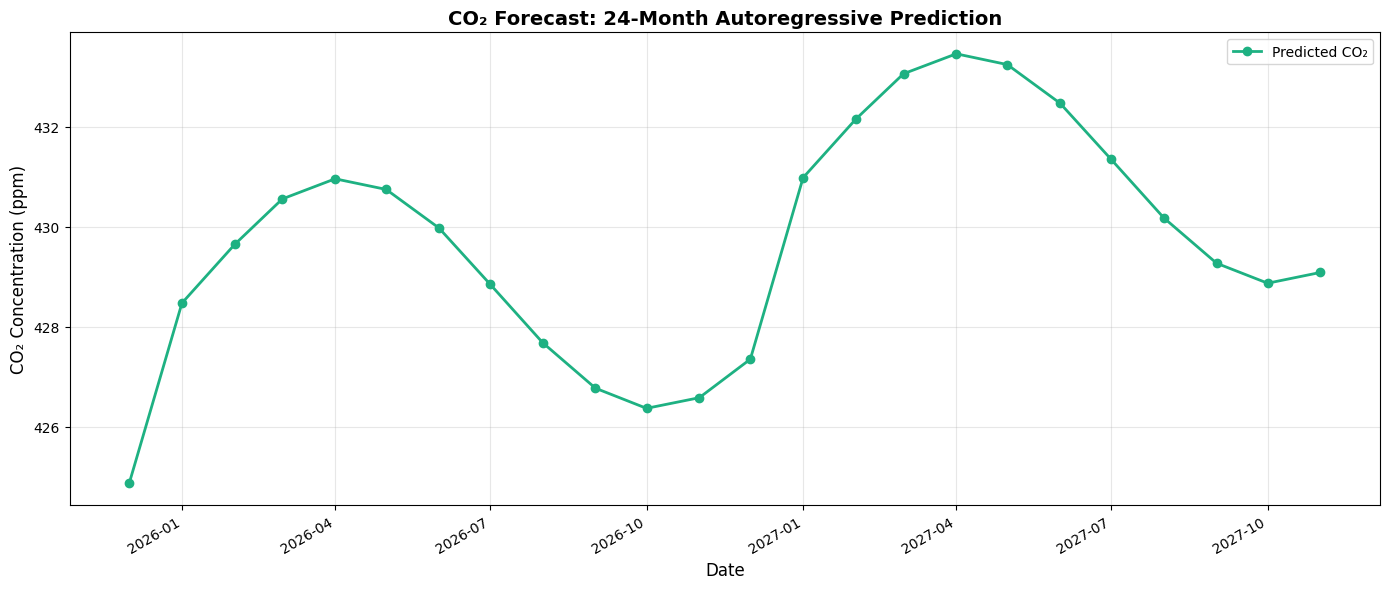

In [8]:
# Plot CO₂ predictions (forecast only, no historical data)

# Prepare data for plotting
predictions_df['date'] = pd.to_datetime(predictions_df['date'])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot predictions only (like airquality notebook)
ax.plot(predictions_df['date'], predictions_df['predicted_co2'], 
        'o-', color='#1EB182', label='Predicted CO₂', linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('CO₂ Concentration (ppm)', fontsize=12)
ax.set_title('CO₂ Forecast: 24-Month Autoregressive Prediction', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Format x-axis dates
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


### Saving the predictions (for monitoring) to a Feature Group

In [9]:
# Prepare predictions for storage in monitoring feature group

today = datetime.now().date()

# Prepare predictions_df for storage
predictions_for_storage = predictions_df.copy()
predictions_for_storage['date'] = pd.to_datetime(predictions_for_storage['date'])
predictions_for_storage = predictions_for_storage.sort_values(by=['date'])

# Add days_before_forecast_day (months ahead: 1, 2, 3, ..., 24)
# For monthly forecasts, we use months_ahead instead of days
predictions_for_storage['days_before_forecast_day'] = range(1, len(predictions_for_storage) + 1)
predictions_for_storage['forecast_date'] = today

# Select columns for storage
predictions_for_storage = predictions_for_storage[['date', 'predicted_co2', 'days_before_forecast_day', 'forecast_date']]

predictions_for_storage


,date,predicted_co2,days_before_forecast_day,forecast_date
0,2025-12-01,424.870651,1,2026-01-02
1,2026-01-01,428.474360,2,2026-01-02
2,2026-02-01,429.646963,3,2026-01-02
3,2026-03-01,430.556179,4,2026-01-02
4,2026-04-01,430.958384,5,2026-01-02
5,2026-05-01,430.745807,6,2026-01-02
6,2026-06-01,429.975408,7,2026-01-02
7,2026-07-01,428.853615,8,2026-01-02
8,2026-08-01,427.681011,9,2026-01-02
9,2026-09-01,426.771795,10,2026-01-02


In [10]:
# Get or create monitoring feature group for CO₂ predictions
# This is a SEPARATE feature group from 'global_co2' - it stores predictions for monitoring
# Using version 3 to avoid conflicts with orphaned tables from versions 1 and 2

co2_monitor_fg = fs.get_or_create_feature_group(
    name='co2_predictions',
    description='CO2 prediction monitoring',
    version=3,
    primary_key=['date', 'days_before_forecast_day'],
    event_time='date'
)

# Insert predictions
co2_monitor_fg.insert(predictions_for_storage, wait=True)
print("Stored CO₂ predictions in monitoring feature group")

2026-01-02 15:35:36,415 INFO: Computing insert statistics
Stored CO₂ predictions in monitoring feature group


### Plot the Hindcast comparing predicted with actual values (1-month prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few months of predictions and observations, you will get data points in this graph.


In [11]:
# Retrieve predictions from monitoring feature group (1-month ahead forecasts)
# Note: We filter by days_before_forecast_day == 1 to get only 1-month ahead predictions.
# Since the primary key is ['date', 'days_before_forecast_day'], if we insert a new prediction
# for the same date with days_before_forecast_day == 1, it will replace the old one (upsert).
# However, the forecast only generates predictions for future dates, so backfilled predictions
# for historical dates remain unchanged. This allows us to evaluate predictions over time.

co2_monitor_fg = fs.get_feature_group(
    name='co2_predictions',
    version=3,
)

monitoring_df = co2_monitor_fg.filter(
    co2_monitor_fg.days_before_forecast_day == 1
).read()

# If there are multiple predictions for the same date (from different forecast runs),
# keep only the most recent one (by forecast_date)
if 'forecast_date' in monitoring_df.columns and len(monitoring_df) > 0:
    monitoring_df['forecast_date'] = pd.to_datetime(monitoring_df['forecast_date'])
    monitoring_df = monitoring_df.sort_values('forecast_date').drop_duplicates(subset=['date'], keep='last')

monitoring_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.06s) 


,date,predicted_co2,days_before_forecast_day,forecast_date
1,2024-11-01,421.646423,1,2025-12-30
2,2024-12-01,422.413089,1,2025-12-30
3,2025-01-01,425.992207,1,2025-12-30
4,2025-02-01,427.166267,1,2025-12-30
5,2025-03-01,428.078241,1,2025-12-30
6,2025-04-01,428.483768,1,2025-12-30
7,2025-05-01,428.274187,1,2025-12-30
8,2025-06-01,427.505654,1,2025-12-30
9,2025-07-01,426.384098,1,2025-12-30
10,2025-08-01,425.210038,1,2025-12-30


In [12]:
# Retrieve actual CO₂ data
co2_actual_fg = fs.get_feature_group(name='global_co2', version=1)
co2_actual_df = co2_actual_fg.read()
co2_actual_df['date'] = pd.to_datetime(co2_actual_df['date'])

co2_actual_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


,date,average,trend,average_unc,average_lag_1,trend_lag_1,average_lag_2,trend_lag_2,average_lag_3,trend_lag_3,...,trend_roll_3,trend_roll_12,year,month,month_sin,month_cos,year_normalized,year_normalized_squared,year_month_sin,year_month_cos
0,1959-03-01,316.649994,315.369995,-0.99,316.489990,315.839996,315.579987,315.519989,314.670013,315.429993,...,315.596659,315.364164,1959,3,1.000000e+00,6.123234e-17,0.0,0.0,0.000000,0.000000e+00
1,1959-04-01,317.720001,315.420013,-0.99,316.649994,315.369995,316.489990,315.839996,315.579987,315.519989,...,315.576660,315.441663,1959,4,8.660254e-01,-5.000000e-01,0.0,0.0,0.000000,-0.000000e+00
2,1959-05-01,318.290009,315.459991,-0.99,317.720001,315.420013,316.649994,315.369995,316.489990,315.839996,...,315.543335,315.463331,1959,5,5.000000e-01,-8.660254e-01,0.0,0.0,0.000000,-0.000000e+00
3,1959-06-01,318.149994,316.000000,-0.99,318.290009,315.459991,317.720001,315.420013,316.649994,315.369995,...,315.416667,315.527496,1959,6,1.224647e-16,-1.000000e+00,0.0,0.0,0.000000,-0.000000e+00
4,1959-07-01,316.540009,315.869995,-0.99,318.149994,316.000000,318.290009,315.459991,317.720001,315.420013,...,315.626668,315.598330,1959,7,-5.000000e-01,-8.660254e-01,0.0,0.0,-0.000000,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2025-07-01,427.869995,427.459991,0.12,429.609985,427.160004,430.510010,427.269989,429.640015,427.140015,...,427.190002,426.155004,2025,7,-5.000000e-01,-8.660254e-01,1.0,1.0,-0.500000,-8.660254e-01
797,2025-08-01,425.480011,427.380005,0.15,427.869995,427.459991,429.609985,427.160004,430.510010,427.269989,...,427.296661,426.348335,2025,8,-8.660254e-01,-5.000000e-01,1.0,1.0,-0.866025,-5.000000e-01
798,2025-09-01,424.369995,427.769989,0.21,425.480011,427.380005,427.869995,427.459991,429.609985,427.160004,...,427.333333,426.555834,2025,9,-1.000000e+00,-1.836970e-16,1.0,1.0,-1.000000,-1.836970e-16
799,2025-10-01,424.869995,428.130005,0.14,424.369995,427.769989,425.480011,427.380005,427.869995,427.459991,...,427.536662,426.750834,2025,10,-8.660254e-01,5.000000e-01,1.0,1.0,-0.866025,5.000000e-01


In [13]:
# Backfill function for CO2 predictions (reuses prediction logic from Cell 7)
def backfill_co2_predictions_for_monitoring(co2_fg, co2_monitor_fg, trend_model, residual_model_gb, bias_correction, year_min, year_max):
    """
    Generate predictions for recent historical dates using the same autoregressive logic as Cell 7.
    This populates the monitoring feature group with backfilled predictions for evaluation.
    """
    # Get recent historical CO2 data (last 24 months for backfill)
    co2_hist = co2_fg.read()
    co2_hist['date'] = pd.to_datetime(co2_hist['date'])
    co2_hist = co2_hist.sort_values('date')
    
    # Get last 24 months of historical data
    last_date = co2_hist['date'].max()
    backfill_start = last_date - pd.DateOffset(months=24)
    co2_recent = co2_hist[co2_hist['date'] >= backfill_start].copy()
    
    if len(co2_recent) < 12:
        print(f"Warning: Only {len(co2_recent)} months of data available for backfill")
        return pd.DataFrame()
    
    # Prepare data similar to Cell 7
    co2_recent['year'] = pd.to_datetime(co2_recent['date']).dt.year
    co2_recent['month'] = pd.to_datetime(co2_recent['date']).dt.month
    historical_average = list(co2_recent['average'].values)
    
    # Calculate historical trend (same as Cell 7)
    historical_trend_features = pd.DataFrame({
        'year': co2_recent['year'],
        'month': co2_recent['month'],
    })
    historical_trend_features['month_sin'] = np.sin(2 * np.pi * historical_trend_features['month'] / 12)
    historical_trend_features['month_cos'] = np.cos(2 * np.pi * historical_trend_features['month'] / 12)
    historical_trend_features['year_normalized'] = (historical_trend_features['year'] - year_min) / (year_max - year_min)
    historical_trend_features['year_normalized_squared'] = historical_trend_features['year_normalized'] ** 2
    historical_trend_features['year_month_sin'] = historical_trend_features['year_normalized'] * historical_trend_features['month_sin']
    historical_trend_features['year_month_cos'] = historical_trend_features['year_normalized'] * historical_trend_features['month_cos']
    
    trend_features = ['year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos']
    historical_trend = list(trend_model.predict(historical_trend_features[trend_features]))
    
    # Use the same helper function from Cell 7 (it's defined there, so we can reference it)
    # Make predictions for each historical date (autoregressive, using only past data)
    predictions_list = []
    for i in range(12, len(co2_recent)):  # Start from index 12 to have enough history
        row = co2_recent.iloc[i]
        avg_history_up_to = historical_average[:i]
        trend_history_up_to = historical_trend[:i]
        
        # Build trend features (same as Cell 7)
        year = row['year']
        month = row['month']
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        year_norm = (year - year_min) / (year_max - year_min)
        year_norm_sq = year_norm ** 2
        year_month_sin = year_norm * month_sin
        year_month_cos = year_norm * month_cos
        
        trend_row = pd.DataFrame([{
            'year_normalized': year_norm,
            'year_normalized_squared': year_norm_sq,
            'month_sin': month_sin,
            'month_cos': month_cos,
            'year_month_sin': year_month_sin,
            'year_month_cos': year_month_cos,
        }])
        trend_pred = float(trend_model.predict(trend_row[trend_features])[0])
        
        # Build residual features using same helper from Cell 7
        resid_feats = make_co2_residual_features_from_history(avg_history_up_to, trend_history_up_to)
        resid_row_df = pd.DataFrame([resid_feats])
        resid_row_df = resid_row_df.drop(columns=[c for c in trend_features if c in resid_row_df.columns])
        
        residual_pred = float(residual_model_gb.predict(resid_row_df)[0])
        co2_pred = trend_pred + residual_pred + bias_correction
        
        predictions_list.append({
            'date': row['date'],
            'predicted_co2': co2_pred,
            'actual_co2': row['average'],
        })
    
    if len(predictions_list) == 0:
        return pd.DataFrame()
    
    hindcast_df = pd.DataFrame(predictions_list)
    hindcast_df['date'] = pd.to_datetime(hindcast_df['date'])
    
    # Prepare for storage
    storage_df = hindcast_df[['date', 'predicted_co2']].copy()
    storage_df['days_before_forecast_day'] = 1
    storage_df['forecast_date'] = datetime.now().date()
    
    # Insert into monitoring feature group
    co2_monitor_fg.insert(storage_df, wait=True)
    print(f"Backfilled {len(storage_df)} CO2 predictions for monitoring")
    
    return hindcast_df


In [14]:
# Merge predictions with actual values for hindcast evaluation
# 
# How this works when new actual data arrives:
# 1. Initially: Backfill creates predictions for last 24 months of historical data
# 2. Each month: Forecast creates predictions for 24 months ahead (future dates only)
# 3. When actual data arrives for a month (e.g., January 2025):
#    - We already have a prediction for that month (made 1 month earlier, e.g., December 2024)
#    - The hindcast merges predictions with actuals, showing a new dot for that month
#    - Backfilled predictions remain unchanged (they're for historical dates)
# 4. The hindcast plot grows over time: each month, a new dot appears showing the comparison
#    for the month that now has actuals
#
# Example timeline:
# - Dec 2024: Hindcast shows Nov 2023 - Nov 2024 (backfilled predictions vs actuals)
# - Jan 2025: Hindcast shows Nov 2023 - Jan 2025 (backfilled + Dec 2024 prediction for Jan 2025 vs actuals)
# - Feb 2025: Hindcast shows Nov 2023 - Feb 2025 (backfilled + Dec 2024 prediction for Jan 2025 + Jan 2025 prediction for Feb 2025 vs actuals)

outcome_df = co2_actual_df[['date', 'average']].rename(columns={'average': 'actual_co2'})
preds_df = monitoring_df[['date', 'predicted_co2']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, backfill predictions for monitoring
# This only runs once initially - after that, new predictions come from monthly forecasts
if len(hindcast_df) == 0:
    hindcast_df = backfill_co2_predictions_for_monitoring(
        co2_fg, 
        co2_monitor_fg, 
        trend_model, 
        residual_model_gb, 
        params['bias_correction'], 
        year_min, 
        year_max
    )

hindcast_df


,date,predicted_co2,actual_co2
0,2024-11-01,421.646423,423.850006
1,2024-12-01,422.413089,425.399994
2,2025-01-01,425.992207,426.649994
3,2025-02-01,427.166267,427.089996
4,2025-03-01,428.078241,428.149994
5,2025-04-01,428.483768,429.640015
6,2025-05-01,428.274187,430.510010
7,2025-06-01,427.505654,429.609985
8,2025-07-01,426.384098,427.869995
9,2025-08-01,425.210038,425.480011


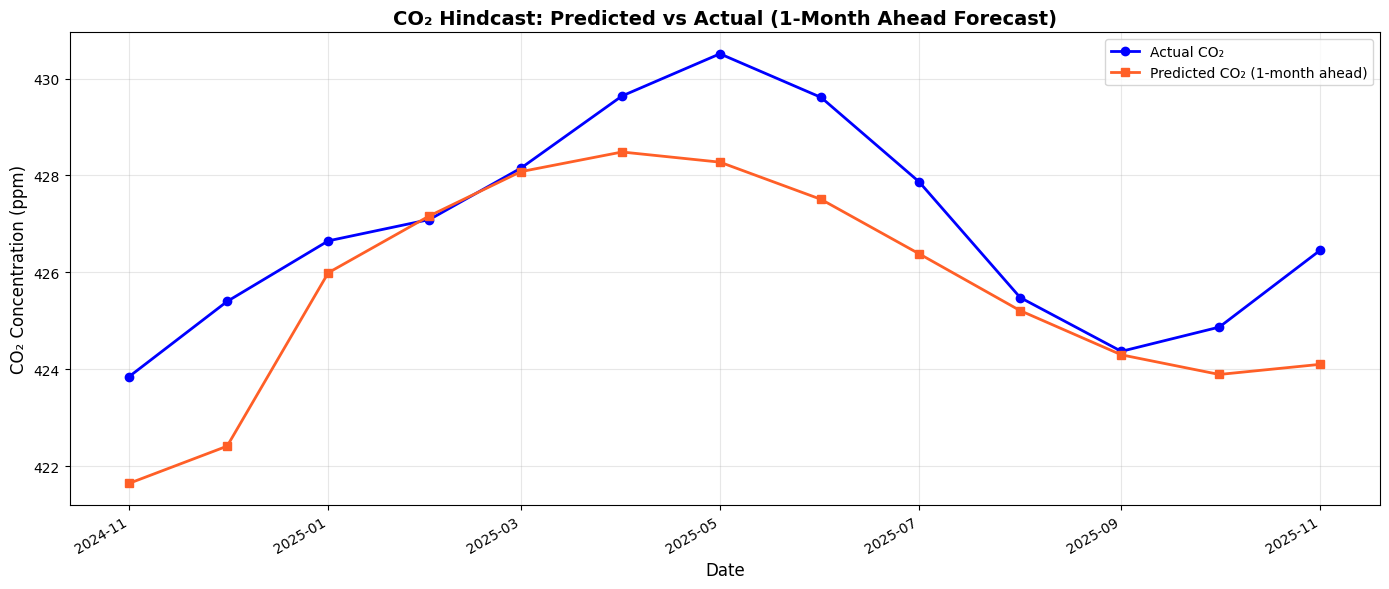

In [15]:
# Plot hindcast: predicted vs actual CO₂

if len(hindcast_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(hindcast_df['date'], hindcast_df['actual_co2'], 
            'o-', color='blue', label='Actual CO₂', linewidth=2, markersize=6)
    ax.plot(hindcast_df['date'], hindcast_df['predicted_co2'], 
            's-', color='#ff5f27', label='Predicted CO₂ (1-month ahead)', linewidth=2, markersize=6)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('CO₂ Concentration (ppm)', fontsize=12)
    ax.set_title('CO₂ Hindcast: Predicted vs Actual (1-Month Ahead Forecast)', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    fig.autofmt_xdate()
    

    plt.tight_layout()
    plt.show()
else:
    print("No hindcast data available yet. This is normal, predictions need time to accumulate actual values for comparison.")


## 🌡️ Inference pipeline for Temperature


In [16]:
model_name_temp = f"global_temperature_trend_residual_model"
print(f"Retrieving model: {model_name_temp}")

retrieved_model_temp = mr.get_model(
    name=model_name_temp,
    version=1,  # Get the latest version
)

fv_temp = retrieved_model_temp.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_temp = retrieved_model_temp.download()

Retrieving model: global_temperature_trend_residual_model
2026-01-02 15:35:47,683 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/1000 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/716718 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/47 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/40205 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/51604 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/171682 elapsed<00:00 remaining<?

In [17]:
# Load Temperature trend + residual models and normalization parameters from the downloaded directory

trend_model_path_temp = Path(saved_model_dir_temp) / "temp_trend_model.pkl"
residual_model_path_temp = Path(saved_model_dir_temp) / "temp_residual_model_gb.pkl"
params_path_temp = Path(saved_model_dir_temp) / "temp_normalization_params.pkl"

print("Loading temperature models from:", saved_model_dir_temp)

trend_model_temp = joblib.load(trend_model_path_temp)
residual_model_gb_temp = joblib.load(residual_model_path_temp)
params_temp = joblib.load(params_path_temp)

bias_correction_temp = params_temp.get("bias_correction_temp", 0.0)

print("Loaded temperature trend_model, residual_model_gb, and bias_correction")

Loading temperature models from: /var/folders/9l/s0ldp1h1453gkrsny8rxfr3w0000gn/T/3e005077-e5d0-45b8-84ab-3ae529d0f49a/global_temperature_trend_residual_model/1
Loaded temperature trend_model, residual_model_gb, and bias_correction


In [18]:
# Get batch data from temperature feature group
# We need historical data (at least 12 months) to build lag/rolling features for predictions

today = datetime.now().date()

temp_fg = fs.get_feature_group(
    name='global_temperature',
    version=1,
)

# Get data from at least 12 months ago to today (to build lag_12 and roll_12 features)
# We'll use this historical data to seed our autoregressive predictions
# Use a longer lookback to ensure we get enough data (accounting for potential gaps)
lookback_months = 18
lookback_date = today - timedelta(days=lookback_months * 30)  # Approximate 18 months

batch_data_temp = temp_fg.filter(
    temp_fg.date >= pd.Timestamp(lookback_date)
).read()

batch_data_temp

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.37s) 


,date,temp_anomaly,temp_anomaly_lag_1,temp_anomaly_lag_2,temp_anomaly_lag_3,temp_anomaly_lag_6,temp_anomaly_lag_12,temp_anomaly_roll_3,temp_anomaly_roll_12,year,month,month_sin,month_cos,year_normalized,year_normalized_squared,year_month_sin,year_month_cos
0,2024-08-01,1.29,1.20,1.20,1.14,1.44,1.19,1.180000,1.310833,2024,8,-8.660254e-01,-5.000000e-01,0.993056,0.986159,-8.600113e-01,-4.965278e-01
1,2024-09-01,1.24,1.29,1.20,1.20,1.39,1.48,1.230000,1.319167,2024,9,-1.000000e+00,-1.836970e-16,0.993056,0.986159,-9.930556e-01,-1.824213e-16
2,2024-10-01,1.32,1.24,1.29,1.20,1.31,1.34,1.243333,1.299167,2024,10,-8.660254e-01,5.000000e-01,0.993056,0.986159,-8.600113e-01,4.965278e-01
3,2024-11-01,1.29,1.32,1.24,1.29,1.14,1.42,1.283333,1.297500,2024,11,-5.000000e-01,8.660254e-01,0.993056,0.986159,-4.965278e-01,8.600113e-01
4,2024-12-01,1.27,1.29,1.32,1.24,1.20,1.37,1.283333,1.286667,2024,12,-2.449294e-16,1.000000e+00,0.993056,0.986159,-2.432285e-16,9.930556e-01
5,2025-01-01,1.37,1.27,1.29,1.32,1.20,1.25,1.293333,1.278333,2025,1,5.000000e-01,8.660254e-01,1.000000,1.000000,5.000000e-01,8.660254e-01
6,2025-02-01,1.25,1.37,1.27,1.29,1.29,1.44,1.310000,1.288333,2025,2,8.660254e-01,5.000000e-01,1.000000,1.000000,8.660254e-01,5.000000e-01
7,2025-03-01,1.36,1.25,1.37,1.27,1.24,1.39,1.296667,1.272500,2025,3,1.000000e+00,6.123234e-17,1.000000,1.000000,1.000000e+00,6.123234e-17
8,2025-04-01,1.23,1.36,1.25,1.37,1.32,1.31,1.326667,1.270000,2025,4,8.660254e-01,-5.000000e-01,1.000000,1.000000,8.660254e-01,-5.000000e-01
9,2025-05-01,1.07,1.23,1.36,1.25,1.29,1.14,1.280000,1.263333,2025,5,5.000000e-01,-8.660254e-01,1.000000,1.000000,5.000000e-01,-8.660254e-01


In [19]:
# Autoregressive multi-month Temperature forecast using historical data to seed lag/rolling features

# Sort batch_data_temp by date to ensure chronological order
batch_data_temp = batch_data_temp.sort_values("date", ascending=True).copy()

# Get year normalization range from FULL historical dataset (same as in training)
# We need the full range, not just the last 12 months
temp_full_hist = temp_fg.read()  # Read all historical data
temp_full_hist['date'] = pd.to_datetime(temp_full_hist['date'])
temp_full_hist['year'] = pd.to_datetime(temp_full_hist['date']).dt.year

year_min_temp = temp_full_hist['year'].min()
year_max_temp = temp_full_hist['year'].max()

print(f"Year normalization range: {year_min_temp} to {year_max_temp}")

# Initialize historical values for autoregressive features
# We prefer at least 12 months of history for lag_12 and roll_12, but can work with less
if len(batch_data_temp) < 6:
    raise ValueError(f"Need at least 6 months of historical data, got {len(batch_data_temp)}")
elif len(batch_data_temp) < 12:
    print(f"Warning: Only {len(batch_data_temp)} months of historical data available. Some lag/roll features may use shorter windows.")

# Extract historical temperature anomaly values
batch_data_temp['date'] = pd.to_datetime(batch_data_temp['date'])
batch_data_temp['year'] = pd.to_datetime(batch_data_temp['date']).dt.year
batch_data_temp['month'] = pd.to_datetime(batch_data_temp['date']).dt.month

historical_temp_anomaly = list(batch_data_temp['temp_anomaly'].values)

# Calculate historical trend values for seeding trend features
historical_trend_features_temp = pd.DataFrame({
    'year': batch_data_temp['year'],
    'month': batch_data_temp['month'],
})
historical_trend_features_temp['month_sin'] = np.sin(2 * np.pi * historical_trend_features_temp['month'] / 12)
historical_trend_features_temp['month_cos'] = np.cos(2 * np.pi * historical_trend_features_temp['month'] / 12)
historical_trend_features_temp['year_normalized'] = (historical_trend_features_temp['year'] - year_min_temp) / (year_max_temp - year_min_temp)
historical_trend_features_temp['year_normalized_squared'] = historical_trend_features_temp['year_normalized'] ** 2
historical_trend_features_temp['year_month_sin'] = historical_trend_features_temp['year_normalized'] * historical_trend_features_temp['month_sin']
historical_trend_features_temp['year_month_cos'] = historical_trend_features_temp['year_normalized'] * historical_trend_features_temp['month_cos']

trend_features_temp = ['year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos']
historical_trend_temp = list(trend_model_temp.predict(historical_trend_features_temp[trend_features_temp]))

# Generate future dates for prediction (24 months ahead)
last_date_temp = pd.to_datetime(batch_data_temp['date'].max())
future_dates_temp = pd.date_range(
    start=last_date_temp + pd.offsets.MonthBegin(1),
    periods=24,
    freq='MS'
)

# Helper function to build residual features from history lists for temperature
# Note: The temperature residual model was trained ONLY on temp_anomaly lag/roll features,
# NOT on trend lag/roll features (unlike CO2 which uses both)
def make_temp_residual_features_from_history(temp_anomaly_history, trend_history):
    """Build residual features from historical temperature anomaly list.
    Note: trend_history parameter is unused but kept for consistency with CO2 function signature."""
    temp_arr = np.array(temp_anomaly_history, dtype=float)
    
    def lag(arr, k):
        if len(arr) < k:
            return np.nan
        return arr[-k]
    
    def roll(arr, k):
        if len(arr) < k:
            return np.nan
        return np.mean(arr[-k:])
    
    return {
        'temp_anomaly_lag_1': lag(temp_arr, 1),
        'temp_anomaly_lag_2': lag(temp_arr, 2),
        'temp_anomaly_lag_3': lag(temp_arr, 3),
        'temp_anomaly_lag_6': lag(temp_arr, 6),
        'temp_anomaly_lag_12': lag(temp_arr, 12),
        'temp_anomaly_roll_3': roll(temp_arr, 3),
        'temp_anomaly_roll_12': roll(temp_arr, 12),
    }

# Initialize predictions list
predictions_temp = []

# Iterate through future dates (autoregressive)
for dt in future_dates_temp:
    year = dt.year
    month = dt.month
    
    # Build time features for this date
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    year_norm = (year - year_min_temp) / (year_max_temp - year_min_temp)
    year_norm_sq = year_norm ** 2
    year_month_sin = year_norm * month_sin
    year_month_cos = year_norm * month_cos
    
    # 1. Predict trend part
    trend_row_temp = pd.DataFrame([{
        'year_normalized': year_norm,
        'year_normalized_squared': year_norm_sq,
        'month_sin': month_sin,
        'month_cos': month_cos,
        'year_month_sin': year_month_sin,
        'year_month_cos': year_month_cos,
    }])
    trend_pred_temp = float(trend_model_temp.predict(trend_row_temp[trend_features_temp])[0])
    
    # 2. Build residual features from historical data
    resid_feats_temp = make_temp_residual_features_from_history(historical_temp_anomaly, historical_trend_temp)
    
    # 3. Predict residual part
    resid_row_df_temp = pd.DataFrame([resid_feats_temp])
    # Remove trend features from residual features (they're not used in residual model)
    resid_row_df_temp = resid_row_df_temp.drop(columns=[c for c in trend_features_temp if c in resid_row_df_temp.columns])
    residual_pred_temp = float(residual_model_gb_temp.predict(resid_row_df_temp)[0])
    
    # 4. Combine trend + residual + bias correction
    temp_pred = trend_pred_temp + residual_pred_temp + bias_correction_temp
    
    predictions_temp.append({
        'date': dt,
        'predicted_temp_anomaly': temp_pred,
        'trend': trend_pred_temp,
        'residual': residual_pred_temp,
    })
    
    # Update histories for next iteration (autoregressive)
    historical_temp_anomaly.append(temp_pred)
    historical_trend_temp.append(trend_pred_temp)

# Convert to DataFrame
predictions_df_temp = pd.DataFrame(predictions_temp)
predictions_df_temp


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 
Year normalization range: 1881 to 2025


,date,predicted_temp_anomaly,trend,residual
0,2025-12-01,1.431117,1.086313,0.344793
1,2026-01-01,1.461413,1.114515,0.346887
2,2026-02-01,1.448843,1.104040,0.344793
3,2026-03-01,1.427504,1.082701,0.344793
4,2026-04-01,1.401020,1.056216,0.344793
5,2026-05-01,1.346766,1.031683,0.315072
6,2026-06-01,1.330757,1.015674,0.315072
7,2026-07-01,1.327563,1.012480,0.315072
8,2026-08-01,1.367233,1.022956,0.344266
9,2026-09-01,1.389098,1.044295,0.344793


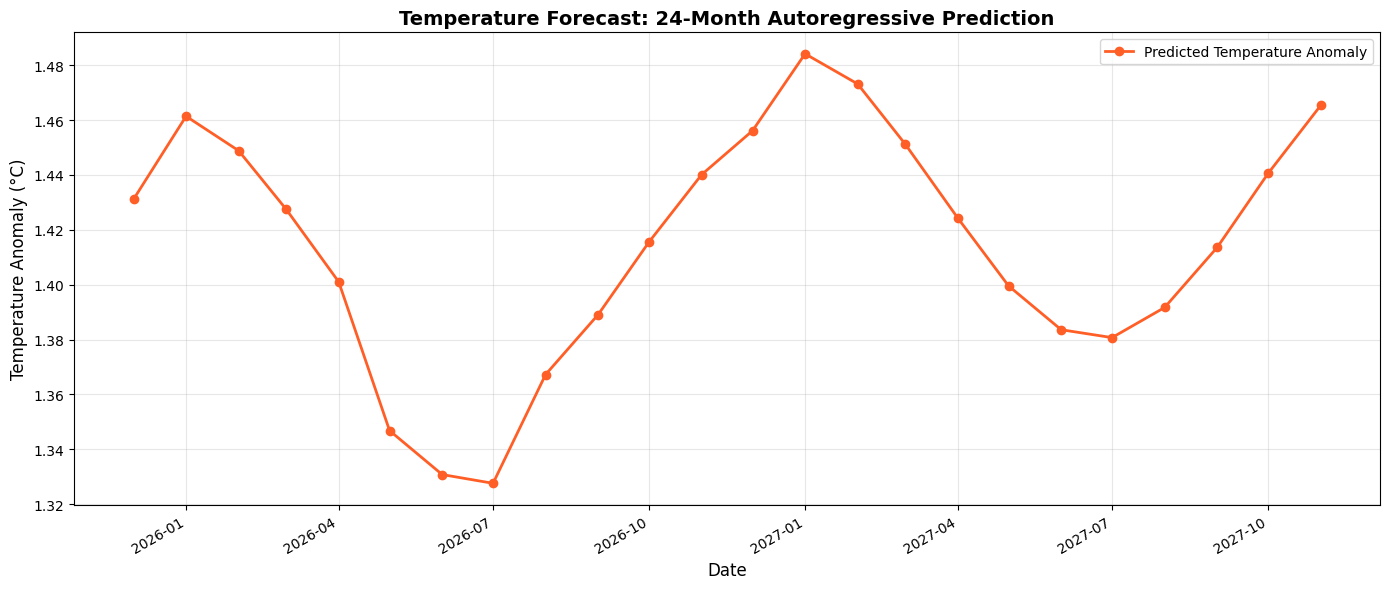

In [20]:
# Plot temperature predictions (forecast only, no historical data)

# Prepare data for plotting
predictions_df_temp['date'] = pd.to_datetime(predictions_df_temp['date'])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot predictions only (like airquality notebook)
ax.plot(predictions_df_temp['date'], predictions_df_temp['predicted_temp_anomaly'], 
        'o-', color='#ff5f27', label='Predicted Temperature Anomaly', linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature Anomaly (°C)', fontsize=12)
ax.set_title('Temperature Forecast: 24-Month Autoregressive Prediction', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Format x-axis dates
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


In [21]:
# Prepare temperature predictions for storage in monitoring feature group

today = datetime.now().date()

# Prepare predictions_df_temp for storage
predictions_for_storage_temp = predictions_df_temp.copy()
predictions_for_storage_temp['date'] = pd.to_datetime(predictions_for_storage_temp['date'])
predictions_for_storage_temp = predictions_for_storage_temp.sort_values(by=['date'])

# Add days_before_forecast_day (months ahead: 1, 2, 3, ..., 24)
# For monthly forecasts, we use months_ahead instead of days
predictions_for_storage_temp['days_before_forecast_day'] = range(1, len(predictions_for_storage_temp) + 1)
predictions_for_storage_temp['forecast_date'] = today

# Select columns for storage
predictions_for_storage_temp = predictions_for_storage_temp[['date', 'predicted_temp_anomaly', 'days_before_forecast_day', 'forecast_date']]

predictions_for_storage_temp


,date,predicted_temp_anomaly,days_before_forecast_day,forecast_date
0,2025-12-01,1.431117,1,2026-01-02
1,2026-01-01,1.461413,2,2026-01-02
2,2026-02-01,1.448843,3,2026-01-02
3,2026-03-01,1.427504,4,2026-01-02
4,2026-04-01,1.401020,5,2026-01-02
5,2026-05-01,1.346766,6,2026-01-02
6,2026-06-01,1.330757,7,2026-01-02
7,2026-07-01,1.327563,8,2026-01-02
8,2026-08-01,1.367233,9,2026-01-02
9,2026-09-01,1.389098,10,2026-01-02


In [22]:
# Get or create monitoring feature group for temperature predictions
# This is a SEPARATE feature group from 'global_temperature' - it stores predictions for monitoring
# Using version 3 to avoid conflicts with orphaned tables from versions 1 and 2

temp_monitor_fg = fs.get_or_create_feature_group(
    name='temperature_predictions',
    description='Temperature prediction monitoring',
    version=3,
    primary_key=['date', 'days_before_forecast_day'],
    event_time='date'
)

# Insert predictions
temp_monitor_fg.insert(predictions_for_storage_temp, wait=True)
print("Stored temperature predictions in monitoring feature group")


2026-01-02 15:36:19,301 INFO: Computing insert statistics
Stored temperature predictions in monitoring feature group


In [23]:
# Retrieve temperature predictions from monitoring feature group (1-month ahead forecasts)
# Note: We filter by days_before_forecast_day == 1 to get only 1-month ahead predictions.
# Since the primary key is ['date', 'days_before_forecast_day'], if we insert a new prediction
# for the same date with days_before_forecast_day == 1, it will replace the old one (upsert).
# However, the forecast only generates predictions for future dates, so backfilled predictions
# for historical dates remain unchanged. This allows us to evaluate predictions over time.

temp_monitor_fg = fs.get_feature_group(
    name='temperature_predictions',
    version=3,
)

monitoring_df_temp = temp_monitor_fg.filter(
    temp_monitor_fg.days_before_forecast_day == 1
).read()

# If there are multiple predictions for the same date (from different forecast runs),
# keep only the most recent one (by forecast_date)
if 'forecast_date' in monitoring_df_temp.columns and len(monitoring_df_temp) > 0:
    monitoring_df_temp['forecast_date'] = pd.to_datetime(monitoring_df_temp['forecast_date'])
    monitoring_df_temp = monitoring_df_temp.sort_values('forecast_date').drop_duplicates(subset=['date'], keep='last')

monitoring_df_temp


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.13s) 


,date,predicted_temp_anomaly,days_before_forecast_day,forecast_date
0,2024-11-01,1.390198,1,2025-12-30
1,2024-12-01,1.406282,1,2025-12-30
2,2025-01-01,1.434628,1,2025-12-30
3,2025-02-01,1.424664,1,2025-12-30
4,2025-03-01,1.403894,1,2025-12-30
5,2025-04-01,1.377884,1,2025-12-30
6,2025-05-01,1.335708,1,2025-12-30
7,2025-06-01,1.220876,1,2025-12-30
8,2025-07-01,1.185220,1,2025-12-30
9,2025-08-01,1.119365,1,2025-12-30


In [24]:
def backfill_temp_predictions_for_monitoring(temp_fg, temp_monitor_fg, trend_model_temp, residual_model_gb_temp, bias_correction_temp, year_min_temp, year_max_temp):
    """
    Generate predictions for recent historical dates using the same autoregressive logic as Cell 23.
    This populates the monitoring feature group with backfilled predictions for evaluation.
    """
    # Get recent historical temperature data (last 24 months for backfill)
    temp_hist = temp_fg.read()
    temp_hist['date'] = pd.to_datetime(temp_hist['date'])
    temp_hist = temp_hist.sort_values('date')
    
    # Get last 24 months of historical data
    last_date = temp_hist['date'].max()
    backfill_start = last_date - pd.DateOffset(months=24)
    temp_recent = temp_hist[temp_hist['date'] >= backfill_start].copy()
    
    if len(temp_recent) < 12:
        print(f"Warning: Only {len(temp_recent)} months of data available for backfill")
        return pd.DataFrame()
    
    # Prepare data similar to Cell 23
    temp_recent['year'] = pd.to_datetime(temp_recent['date']).dt.year
    temp_recent['month'] = pd.to_datetime(temp_recent['date']).dt.month
    historical_temp_anomaly = list(temp_recent['temp_anomaly'].values)
    
    # Calculate historical trend (same as Cell 23)
    historical_trend_features_temp = pd.DataFrame({
        'year': temp_recent['year'],
        'month': temp_recent['month'],
    })
    historical_trend_features_temp['month_sin'] = np.sin(2 * np.pi * historical_trend_features_temp['month'] / 12)
    historical_trend_features_temp['month_cos'] = np.cos(2 * np.pi * historical_trend_features_temp['month'] / 12)
    historical_trend_features_temp['year_normalized'] = (historical_trend_features_temp['year'] - year_min_temp) / (year_max_temp - year_min_temp)
    historical_trend_features_temp['year_normalized_squared'] = historical_trend_features_temp['year_normalized'] ** 2
    historical_trend_features_temp['year_month_sin'] = historical_trend_features_temp['year_normalized'] * historical_trend_features_temp['month_sin']
    historical_trend_features_temp['year_month_cos'] = historical_trend_features_temp['year_normalized'] * historical_trend_features_temp['month_cos']
    
    trend_features_temp = ['year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos']
    historical_trend_temp = list(trend_model_temp.predict(historical_trend_features_temp[trend_features_temp]))
    
    # Use the same helper function from Cell 23 (it's defined there, so we can reference it)
    # Make predictions for each historical date (autoregressive, using only past data)
    predictions_list = []
    for i in range(12, len(temp_recent)):  # Start from index 12 to have enough history
        row = temp_recent.iloc[i]
        temp_anomaly_history_up_to = historical_temp_anomaly[:i]
        trend_history_up_to = historical_trend_temp[:i]
        
        # Build trend features (same as Cell 23)
        year = row['year']
        month = row['month']
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        year_norm = (year - year_min_temp) / (year_max_temp - year_min_temp)
        year_norm_sq = year_norm ** 2
        year_month_sin = year_norm * month_sin
        year_month_cos = year_norm * month_cos
        
        trend_row_temp = pd.DataFrame([{
            'year_normalized': year_norm,
            'year_normalized_squared': year_norm_sq,
            'month_sin': month_sin,
            'month_cos': month_cos,
            'year_month_sin': year_month_sin,
            'year_month_cos': year_month_cos,
        }])
        trend_pred_temp = float(trend_model_temp.predict(trend_row_temp[trend_features_temp])[0])
        
        # Build residual features using same helper from Cell 23
        resid_feats_temp = make_temp_residual_features_from_history(temp_anomaly_history_up_to, trend_history_up_to)
        resid_row_df_temp = pd.DataFrame([resid_feats_temp])
        resid_row_df_temp = resid_row_df_temp.drop(columns=[c for c in trend_features_temp if c in resid_row_df_temp.columns])
        
        residual_pred_temp = float(residual_model_gb_temp.predict(resid_row_df_temp)[0])
        temp_pred = trend_pred_temp + residual_pred_temp + bias_correction_temp
        
        predictions_list.append({
            'date': row['date'],
            'predicted_temp_anomaly': temp_pred,
            'actual_temp_anomaly': row['temp_anomaly'],
        })
    
    if len(predictions_list) == 0:
        return pd.DataFrame()
    
    hindcast_df_temp = pd.DataFrame(predictions_list)
    hindcast_df_temp['date'] = pd.to_datetime(hindcast_df_temp['date'])
    
    # Prepare for storage
    storage_df = hindcast_df_temp[['date', 'predicted_temp_anomaly']].copy()
    storage_df['days_before_forecast_day'] = 1
    storage_df['forecast_date'] = datetime.now().date()
    
    # Insert into monitoring feature group
    temp_monitor_fg.insert(storage_df, wait=True)
    print(f"Backfilled {len(storage_df)} temperature predictions for monitoring")
    
    return hindcast_df_temp


In [25]:
historical_trend_temp = list(trend_model_temp.predict(historical_trend_features_temp[trend_features_temp]))

In [26]:
# Retrieve actual temperature data
temp_actual_fg = fs.get_feature_group(name='global_temperature', version=1)
temp_actual_df = temp_actual_fg.read()
temp_actual_df['date'] = pd.to_datetime(temp_actual_df['date'])

temp_actual_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


,date,temp_anomaly,temp_anomaly_lag_1,temp_anomaly_lag_2,temp_anomaly_lag_3,temp_anomaly_lag_6,temp_anomaly_lag_12,temp_anomaly_roll_3,temp_anomaly_roll_12,year,month,month_sin,month_cos,year_normalized,year_normalized_squared,year_month_sin,year_month_cos
0,1881-01-01,-0.20,-0.18,-0.23,-0.24,-0.19,-0.19,-0.216667,-0.178333,1881,1,0.500000,8.660254e-01,0.0,0.0,0.000000,0.000000e+00
1,1881-02-01,-0.14,-0.20,-0.18,-0.23,-0.11,-0.25,-0.203333,-0.179167,1881,2,0.866025,5.000000e-01,0.0,0.0,0.000000,0.000000e+00
2,1881-03-01,0.03,-0.14,-0.20,-0.18,-0.15,-0.10,-0.173333,-0.170000,1881,3,1.000000,6.123234e-17,0.0,0.0,0.000000,0.000000e+00
3,1881-04-01,0.05,0.03,-0.14,-0.20,-0.24,-0.17,-0.103333,-0.159167,1881,4,0.866025,-5.000000e-01,0.0,0.0,0.000000,-0.000000e+00
4,1881-05-01,0.06,0.05,0.03,-0.14,-0.23,-0.11,-0.020000,-0.140833,1881,5,0.500000,-8.660254e-01,0.0,0.0,0.000000,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,2025-07-01,1.02,1.05,1.07,1.23,1.37,1.20,1.116667,1.245000,2025,7,-0.500000,-8.660254e-01,1.0,1.0,-0.500000,-8.660254e-01
1735,2025-08-01,1.15,1.02,1.05,1.07,1.25,1.29,1.046667,1.230000,2025,8,-0.866025,-5.000000e-01,1.0,1.0,-0.866025,-5.000000e-01
1736,2025-09-01,1.24,1.15,1.02,1.05,1.36,1.24,1.073333,1.218333,2025,9,-1.000000,-1.836970e-16,1.0,1.0,-1.000000,-1.836970e-16
1737,2025-10-01,1.19,1.24,1.15,1.02,1.23,1.32,1.136667,1.218333,2025,10,-0.866025,5.000000e-01,1.0,1.0,-0.866025,5.000000e-01


In [27]:
outcome_df_temp = temp_actual_df[['date', 'temp_anomaly']].rename(columns={'temp_anomaly': 'actual_temp_anomaly'})
preds_df_temp = monitoring_df_temp[['date', 'predicted_temp_anomaly']]

hindcast_df_temp = pd.merge(preds_df_temp, outcome_df_temp, on="date")
hindcast_df_temp = hindcast_df_temp.sort_values(by=['date'])

# If there are no outcomes for predictions yet, backfill predictions for monitoring
# This only runs once initially - after that, new predictions come from monthly forecasts
if len(hindcast_df_temp) == 0:
    hindcast_df_temp = backfill_temp_predictions_for_monitoring(
        temp_fg, 
        temp_monitor_fg, 
        trend_model_temp, 
        residual_model_gb_temp, 
        bias_correction_temp, 
        year_min_temp, 
        year_max_temp
    )

hindcast_df_temp


,date,predicted_temp_anomaly,actual_temp_anomaly
0,2024-11-01,1.390198,1.29
1,2024-12-01,1.406282,1.27
2,2025-01-01,1.434628,1.37
3,2025-02-01,1.424664,1.25
4,2025-03-01,1.403894,1.36
5,2025-04-01,1.377884,1.23
6,2025-05-01,1.335708,1.07
7,2025-06-01,1.220876,1.05
8,2025-07-01,1.185220,1.02
9,2025-08-01,1.119365,1.15


### Plot the Temperature Hindcast comparing predicted with actual values (1-month prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few months of predictions and observations, you will get data points in this graph.


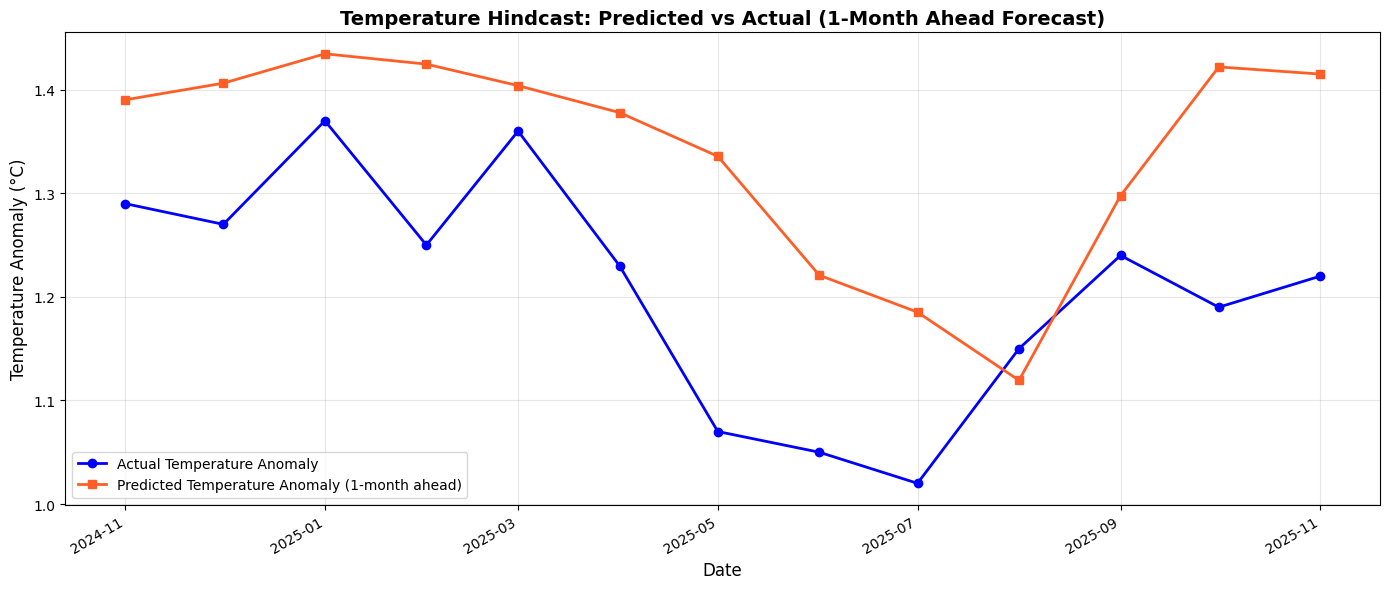

In [28]:
# Plot hindcast: predicted vs actual temperature

if len(hindcast_df_temp) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(hindcast_df_temp['date'], hindcast_df_temp['actual_temp_anomaly'], 
            'o-', color='blue', label='Actual Temperature Anomaly', linewidth=2, markersize=6)
    ax.plot(hindcast_df_temp['date'], hindcast_df_temp['predicted_temp_anomaly'], 
            's-', color='#ff5f27', label='Predicted Temperature Anomaly (1-month ahead)', linewidth=2, markersize=6)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature Anomaly (°C)', fontsize=12)
    ax.set_title('Temperature Hindcast: Predicted vs Actual (1-Month Ahead Forecast)', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    fig.autofmt_xdate()
    

    plt.tight_layout()
    plt.show()
else:
    print("No hindcast data available yet. This is normal, predictions need time to accumulate actual values for comparison.")
